In [2]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), # データオーギュメンテーション
                transforms.RandomHorizontalFlip(), # データオーギュメンテーション
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

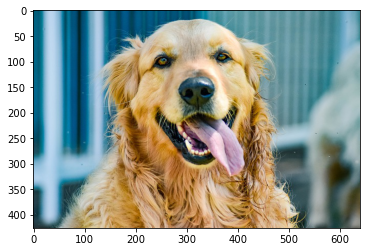

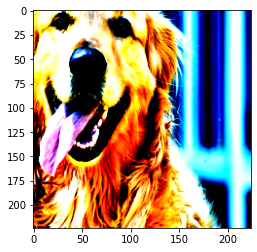

In [4]:
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [5]:
def make_datapath_list(phase="train"):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg',
 './data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg',
 './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 './data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg',
 './data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg',
 './data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg',
 './data/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg',
 './data/hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg',
 './data/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 './data/hymenoptera_data/train/bees/266644509_d30bb16a1b.jpg',
 './data/hymenoptera_data/train/bees/2470492904_837e97800d.jpg',
 './data/hymenoptera_data/train/bees/2053200300_8911ef438a.jpg',
 './data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 './data/hymenoptera_data/train/bees/473618094_8ffdcab215.jpg',
 './data/hymenoptera_data/train/bees/150013791_969d9a968b.jpg',
 './data/hymenoptera_data/trai

In [6]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform # 前処理クラスのインスタンス
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
            
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label

train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


In [7]:
# ミニバッチのサイズを指定
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = { "train": train_dataloader, "val": val_dataloader }
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(
    batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0])


In [9]:
use_pretrained = True # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [10]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [11]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
print("--------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
--------------
[Parameter containing:
tensor([[ 0.0090,  0.0155, -0.0083,  ...,  0.0052, -0.0150, -0.0074],
        [-0.0141, -0.0123,  0.0025,  ...,  0.0012, -0.0116, -0.0023]],
       requires_grad=True), Parameter containing:
tensor([-0.0062, -0.0103], requires_grad=True)]


In [12]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [17]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('---------------')
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # モデルを訓練モードに
            else:
                net.eval() # モデルを検証モードに
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # 未学習時の検証性能を高めるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue
                
            # データローダからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {: 4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [18]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
---------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss:  0.734449 Acc: 0.5163
Epoch 2/2
---------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss:  0.458130 Acc: 0.7778


100%|██████████| 5/5 [00:59<00:00, 11.86s/it]

val Loss:  0.190433 Acc: 0.9346
